In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

## 1. Load data

In [3]:
file = 'data_banknote_authentication.txt'
data = pd.read_csv(file, header=None, names=['variance', 'skewness', 'curtosis', 'entropy', 'class'])
data.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


## Drop the label and make the data for unsupervised clustering

In [4]:
data_unsupervised = data.drop(['class'], axis=1)

## 2. Visualize the features in detail

Since now we do not know the ground truth, true banknote or fake banknote, we can only explore the feature similarity/distance among all the notes. **To quantify and calculate the feature similarity distance between varied banknotes, we need to rescale all the features into a same scale.** Therefore, we need to examine the distribution of each feature more carefully than what we have done in logistic regression.

In more practical words, unlike the visualization for logistic regression, we use histogram to investigate the feature distribution in more detail.

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns

In [6]:
def FeatureDistribution(feature):
    fig = plt.figure(figsize=(8,3.5))
    sns.histplot(data_unsupervised.loc[:, feature], color='r', kde=True)
    plt.xlabel(feature)
    plt.ylabel('density')
    #plt.savefig("figures/{}_total.png".format(feature), bbox_inches='tight')
    plt.show()

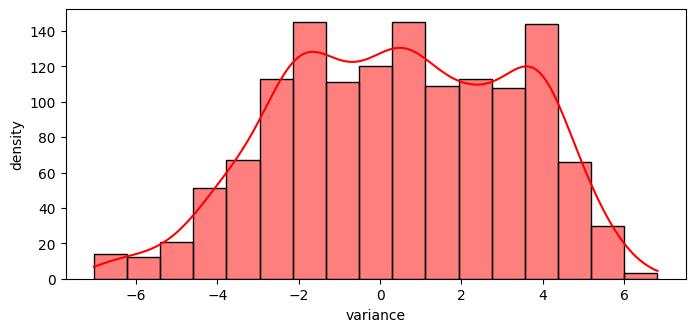

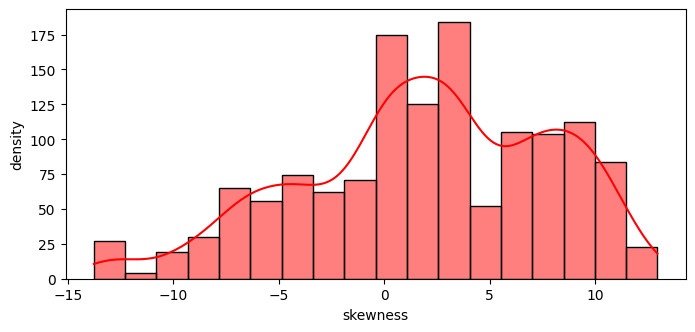

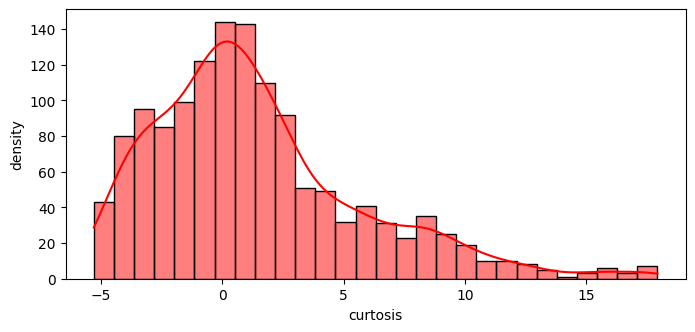

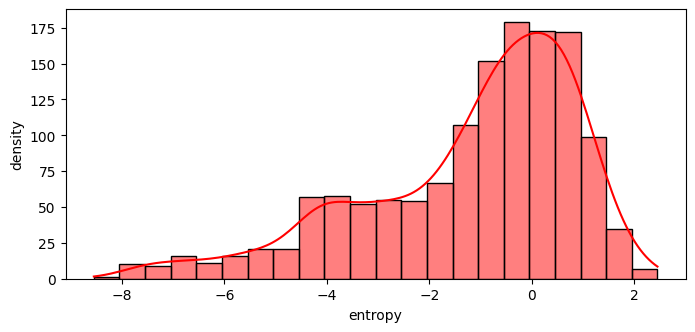

In [7]:
FeatureDistribution('variance')
FeatureDistribution('skewness')
FeatureDistribution('curtosis')
FeatureDistribution('entropy')

- `Variance` has Gaussian-like distribution, peaking around the center, and dropping gradually in both sides. Although the peak around the center is not sharp, the distriibution is probably a combination of two Gaussian distributions. We should apply **normalization** to `variance`.

- `Skewness` also has a Gaussian-like distribution, very likely to be a combination of two or three Gaussian distributions. I will apply **normalization** to `skewness` as well.
  
- `curtosis` and `entropy` are not gaussion-distributed. Both `curtosis` and `entropy` have peaks toward to one end, but neither of them has perfect power-law distribution. The better way to **rescale/standardize** them is to **create quantiles**.

## 3. Feature engineering: normalization & quantile scaling

#### 3.1 Normalization for `variance` and `skewness`

In [8]:
def FeatureNormalization(feature):
    norm_feature = '{}_norm'.format(feature)
    data_unsupervised[norm_feature] = (data_unsupervised[feature] - data_unsupervised[feature].mean())/data_unsupervised[feature].std()

In [9]:
normalization_features = ['variance', 'skewness']

for feature in normalization_features:
    FeatureNormalization(feature)

#### 3.2 Create quantile for `curtosis` and `entropy`

In [10]:
def FeatureQuantile(feature, numQuant):
    quant_feature = '{}_quant'.format(feature)
    scale_feature = '{}_scale'.format(feature)
    data_unsupervised[quant_feature] = pd.qcut(data_unsupervised[feature], numQuant, duplicates='drop', labels=False)
    data_unsupervised[scale_feature] = (data_unsupervised[quant_feature] - data_unsupervised[quant_feature].min()) / (data_unsupervised[quant_feature].max() - data_unsupervised[quant_feature].min())

In [11]:
quantile_features = ['curtosis', 'entropy']
num_quantiles = 10

for feature in quantile_features:
    FeatureQuantile(feature, num_quantiles)

In [12]:
data_unsupervised

,variance,skewness,curtosis,entropy,variance_norm,skewness_norm,curtosis_quant,curtosis_scale,entropy_quant,entropy_scale
0,3.62160,8.66610,-2.8073,-0.44699,1.121397,1.149036,1,0.111111,5,0.555556
1,4.54590,8.16740,-2.4586,-1.46210,1.446538,1.064065,1,0.111111,3,0.333333
2,3.86600,-2.63830,1.9242,0.10645,1.207369,-0.777069,6,0.666667,6,0.666667
3,3.45660,9.52280,-4.0112,-3.59440,1.063355,1.295005,0,0.000000,1,0.111111
4,0.32924,-4.45520,4.5718,-0.98880,-0.036758,-1.086642,8,0.888889,4,0.444444
...,...,...,...,...,...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,-0.009707,-0.097657,2,0.222222,5,0.555556
1368,-1.38870,-4.87730,6.4774,0.34179,-0.641079,-1.158562,8,0.888889,7,0.777778
1369,-3.75030,-13.45860,17.5932,-2.77710,-1.471820,-2.620690,9,1.000000,2,0.222222
1370,-3.56370,-8.38270,12.3930,-1.28230,-1.406180,-1.755831,9,1.000000,3,0.333333


#### 3.3 Drop unprocessed features for clustering

In [13]:
data_unsupervised = data_unsupervised.drop(
                     ['variance', 'skewness', 'curtosis', 'entropy', 'curtosis_quant', 'entropy_quant'], 
                     axis=1)
data_unsupervised.head()

,variance_norm,skewness_norm,curtosis_scale,entropy_scale
0,1.121397,1.149036,0.111111,0.555556
1,1.446538,1.064065,0.111111,0.333333
2,1.207369,-0.777069,0.666667,0.666667
3,1.063355,1.295005,0.000000,0.111111
4,-0.036758,-1.086642,0.888889,0.444444


## 4. K-Means clustering

Without the ground truth (true or fake banknotes), my goal here is to separate all the banknotes into **two** clusters. These **two** clusters will correpond to true and fake banknotes in prediction, though we will not know the exact relation between the model clusters and true-or-fake banknotes.

I use K-Means clustering divide the bank notes. K-means is an unsupervised learning algorithm to segment a dataset into `K` clusters. I set `K = 2` here. 

In [14]:
from sklearn.cluster import KMeans

In [15]:
kmeans_model = KMeans(n_clusters=2, random_state=0, n_init="auto")
kmeans_model.fit(data_unsupervised)

KMeans(n_clusters=2, random_state=0)

In [16]:
labels = kmeans_model.labels_
data_results = data_unsupervised.copy()
data_results['cluster'] = labels
data_results

,variance_norm,skewness_norm,curtosis_scale,entropy_scale,cluster
0,1.121397,1.149036,0.111111,0.555556,0
1,1.446538,1.064065,0.111111,0.333333,0
2,1.207369,-0.777069,0.666667,0.666667,0
3,1.063355,1.295005,0.000000,0.111111,0
4,-0.036758,-1.086642,0.888889,0.444444,1
...,...,...,...,...,...
1367,-0.009707,-0.097657,0.222222,0.555556,0
1368,-0.641079,-1.158562,0.888889,0.777778,1
1369,-1.471820,-2.620690,1.000000,0.222222,1
1370,-1.406180,-1.755831,1.000000,0.333333,1


If cluster-0 is true banknote, then cluster-1 is false banknote, or vice versa.

***Note: Since the clustering is unsupervised and there is no ground truth, K-Means clustering is very dependent on the initial centroids of the clusters that are chosen randomly by the algorithm. When K-Means clustering is not suitable for dataset, the initial centroids will easily become extreme, hence unreliable and unstable clustering result. To examine this, it is better to run K-Means clustering multiple times and check cluster centroids.***

#### 4.1 Examine model stability

In [21]:
centroids = kmeans_model.cluster_centers_

In [22]:
variance_centroids = pd.DataFrame(data = {'class-0': [centroids[0, 0]], \
                                              'class-1': [centroids[1, 0]]})
skewness_centroids = pd.DataFrame(data = {'class-0': [centroids[0, 1]], \
                                              'class-1': [centroids[1, 1]]})
curtosis_centroids = pd.DataFrame(data = {'class-0': [centroids[0, 2]], \
                                              'class-1': [centroids[1, 2]]})
entropy_centroids = pd.DataFrame(data = {'class-0': [centroids[0, 3]], \
                                              'class-1': [centroids[1, 3]]})

In [23]:
n_iter = 7
centers = []

for i in range(n_iter):
    kmeans_model = KMeans(n_clusters=2, n_init="auto")
    kmeans_model.fit(data_unsupervised)
    
    labels = kmeans_model.labels_
    result_col = "cluster_{}".format(i+1)
    data_results[result_col] = labels

    centroids = kmeans_model.cluster_centers_

    variance_centroids.loc[len(variance_centroids)] = centroids[:, 0]
    skewness_centroids.loc[len(skewness_centroids)] = centroids[:, 1]
    curtosis_centroids.loc[len(curtosis_centroids)] = centroids[:, 2]
    entropy_centroids.loc[len(entropy_centroids)] = centroids[:, 3]

In [24]:
variance_centroids

,class-0,class-1
0,0.639278,-0.844799
1,0.640610,-0.844047
2,-0.844799,0.639278
3,-0.844799,0.639278
4,-0.850047,0.633750
5,-0.844799,0.639278
6,0.614454,-0.899067
7,0.640827,-0.846846


In [25]:
skewness_centroids

,class-0,class-1
0,0.493364,-0.651975
1,0.493770,-0.650576
2,-0.651975,0.493364
3,-0.651975,0.493364
4,-0.657598,0.490270
5,-0.651975,0.493364
6,0.459320,-0.672076
7,0.491621,-0.649671


In [26]:
curtosis_centroids

,class-0,class-1
0,0.383412,0.653882
1,0.383903,0.652778
2,0.653882,0.383412
3,0.653882,0.383412
4,0.657755,0.382245
5,0.653882,0.383412
6,0.387457,0.664472
7,0.384550,0.652378


In [27]:
entropy_centroids

,class-0,class-1
0,0.478873,0.527355
1,0.479345,0.526652
2,0.527355,0.478873
3,0.527355,0.478873
4,0.528252,0.478513
5,0.527355,0.478873
6,0.480436,0.528027
7,0.479442,0.526603


In [28]:
data_results

,variance_norm,skewness_norm,curtosis_scale,entropy_scale,cluster,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7
0,1.121397,1.149036,0.111111,0.555556,0,0,1,1,1,1,0,0
1,1.446538,1.064065,0.111111,0.333333,0,0,1,1,1,1,0,0
2,1.207369,-0.777069,0.666667,0.666667,0,0,1,1,1,1,0,0
3,1.063355,1.295005,0.000000,0.111111,0,0,1,1,1,1,0,0
4,-0.036758,-1.086642,0.888889,0.444444,1,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1367,-0.009707,-0.097657,0.222222,0.555556,0,0,1,1,1,1,0,0
1368,-0.641079,-1.158562,0.888889,0.777778,1,1,0,0,0,0,1,1
1369,-1.471820,-2.620690,1.000000,0.222222,1,1,0,0,0,0,1,1
1370,-1.406180,-1.755831,1.000000,0.333333,1,1,0,0,0,0,1,1


- The cluster centroids are stable for all the four features.

- The results seem stable across iterations - when the class change to 0 from 1 in one iteration, the class also change to 1 from 0 in that iteration.

#### 4.2 Visualize stability

In [44]:
def StabilityVisualization(feature, type_centroid):
    centroid_feature = f"{feature}_centroids"

    if feature in ["variance", "skewness"]:
        feature = f"{feature}_norm"
    else:
        feature = f"{feature}_scale"

    data_0 = data_results[data_results['cluster'] == 0]
    data_1 = data_results[data_results['cluster'] == 1]

    fig = plt.figure(figsize=(8, 5))
    sns.histplot(data_0[feature], color='b', kde=True, label="Class 0")
    sns.histplot(data_1[feature], color='r', kde=True, label="Class 1")

    plt.axvline(x = type_centroid['class-0'][0], color = 'b', label="Base Centroid 0")
    plt.axvline(x = type_centroid['class-1'][0], color = 'r', label="Base Centroid 1")

    for i in range(7):

        plt.axvline(x = type_centroid['class-0'][i+1], color = 'b', linestyle = '--', label="{}-Centroid 0".format(i+1))
        plt.axvline(x = type_centroid['class-1'][i+1], color = 'r', linestyle = '--', label="{}-Centroid 1".format(i+1))
        plt.xlabel(feature)
        plt.ylabel('density')
        plt.legend(loc="upper left", fontsize=9)
    plt.savefig("figures/{}_centroids.png".format(feature), bbox_inches='tight')
    plt.show()

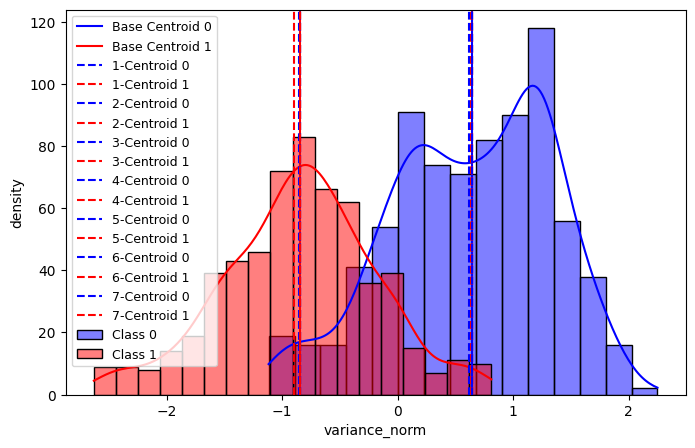

In [45]:
StabilityVisualization("variance", variance_centroids)

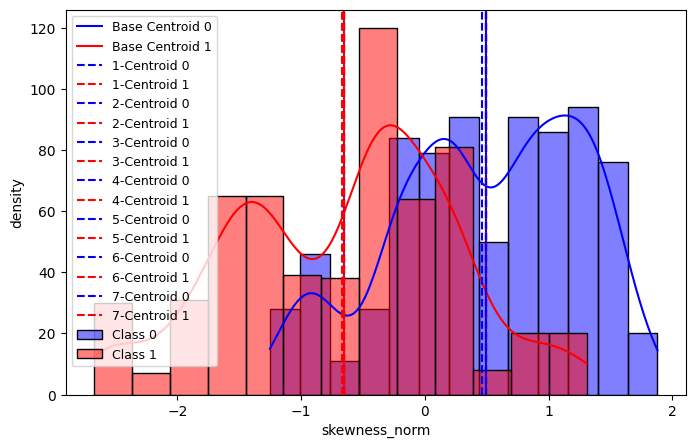

In [46]:
StabilityVisualization("skewness", skewness_centroids)

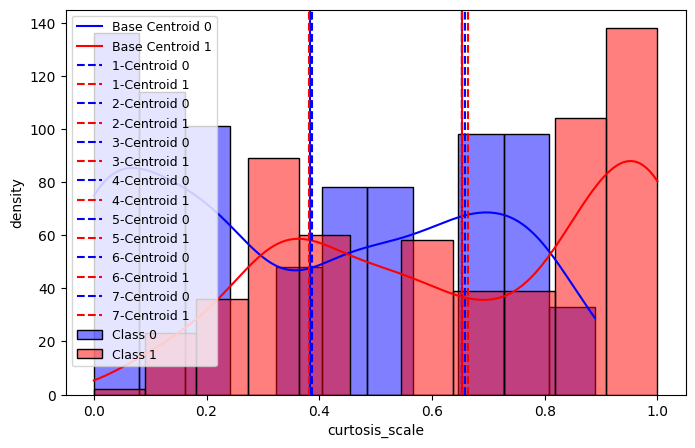

In [47]:
StabilityVisualization("curtosis", curtosis_centroids)

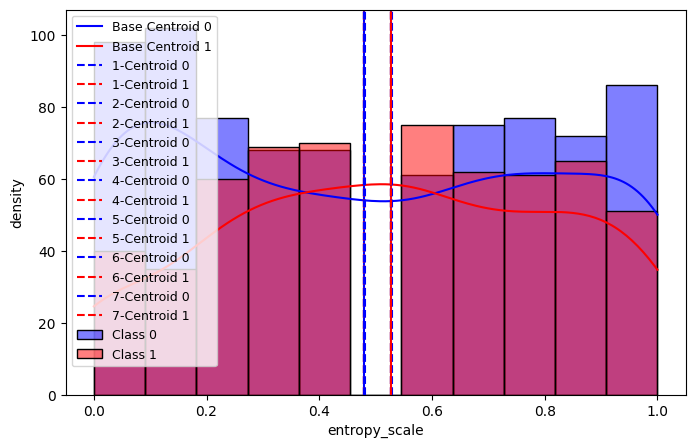

In [48]:
StabilityVisualization("entropy", entropy_centroids)

- As shown in the figures, the two centroids (vertical lines) are around the same places across different iterations for all four features. ***Our K-Means clustering is stable.*** 

- As long as most of objects in one cluster stay in a same cluster, it does not matter that objects are categorized as another cluster in another iteration. For our two-cluster case here, it is completely fine and normal that cluster-0 and cluster-1 switch to each other in varied K-Means cluster runs.

- ***Therefore, K-Means clustering works well on our dataset for separating fake banknotes from true banknotes.***

## 5. Evaluate the model

Now I would like to check the quality and performance of our K-Means clustering model. Since K-Means clustering is stable across various iterations, I will use our very first result for the evaluation.

In [34]:
# Keep only the very first clustering
data_results = data_results.drop(['cluster_1', 'cluster_2', 'cluster_3',
                                  'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7'], axis=1)
data_results

,variance_norm,skewness_norm,curtosis_scale,entropy_scale,cluster
0,1.121397,1.149036,0.111111,0.555556,0
1,1.446538,1.064065,0.111111,0.333333,0
2,1.207369,-0.777069,0.666667,0.666667,0
3,1.063355,1.295005,0.000000,0.111111,0
4,-0.036758,-1.086642,0.888889,0.444444,1
...,...,...,...,...,...
1367,-0.009707,-0.097657,0.222222,0.555556,0
1368,-0.641079,-1.158562,0.888889,0.777778,1
1369,-1.471820,-2.620690,1.000000,0.222222,1
1370,-1.406180,-1.755831,1.000000,0.333333,1


#### 5.1 Cardinality versus magnitude

**Cardinality** is the number of samples in a cluster. **Magnitude** is the sum of the distances between each sample and its cluster centroid. Cardinality and magnitude can help us to find outliers. For example, if a cluster has average cardinality but large magnitude, then it is very likely that this cluser contains outliers.

In [35]:
# Calculate cardinality
card_0 = len(np.where(data_results['cluster'] == 0)[0])
card_1 = len(np.where(data_results['cluster'] == 1)[0])
cardinality = np.array([card_0, card_1])

In [36]:
# Calculate magnitude
def Distance_2_Centroid(point, centroid):
    dist = np.linalg.norm(point - centroid)

    return dist


features = data_results.drop(['cluster'], axis=1)

magnitude_0 = 0
magnitude_1 = 0
for i in range(len(features)):
    if data_results['cluster'][i] == 0:
        magnitude_0 += Distance_2_Centroid(np.array(features.iloc[i, :]), np.array([variance_centroids['class-0'][0], \
                                                                                    skewness_centroids['class-0'][0], \
                                                                                    curtosis_centroids['class-0'][0], \
                                                                                    entropy_centroids['class-0'][0]]))
    else:
        magnitude_1 += Distance_2_Centroid(np.array(features.iloc[i, :]), np.array([variance_centroids['class-1'][0], \
                                                                                    skewness_centroids['class-1'][0], \
                                                                                    curtosis_centroids['class-1'][0], \
                                                                                    entropy_centroids['class-1'][0]]))

magnitude = [magnitude_0, magnitude_1]

Text(0.5, 1.0, 'Magnitude')

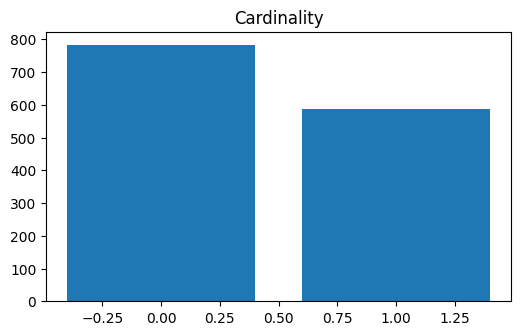

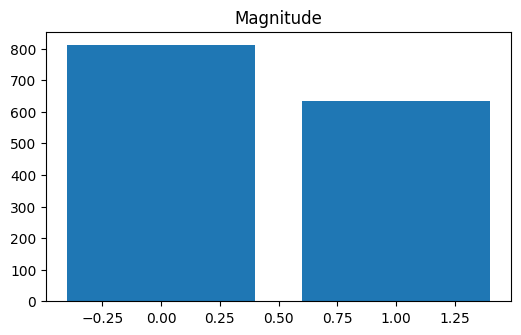

In [37]:
fig = plt.figure(figsize=(6, 3.5))
plt.bar([0, 1], cardinality)
plt.title('Cardinality')

fig = plt.figure(figsize=(6, 3.5))
plt.bar([0, 1], magnitude)
plt.title('Magnitude')

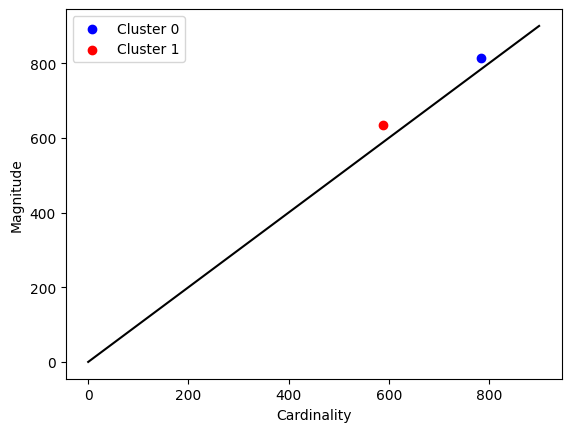

In [38]:
plt.scatter(cardinality[0], magnitude[0], color='b', label='Cluster 0')
plt.scatter(cardinality[1], magnitude[1], color='r', label='Cluster 1')
plt.plot([0, 900], [0, 900], color='black')
plt.xlabel('Cardinality')
plt.ylabel('Magnitude')
plt.legend()

Our cardinality-magnitude metrics look reasonable: 

- From the bar plots, we can already see that cardinality and magnitude are very likely at the same trends. Cluster 0 has both higher cardinality and higher magnitude, and cluster 1 has both lower cardinality and lower magnitude. Furthermore, the levels of difference between cluster 0 and cluster 1 are similar in both cardinality and magnitude.
  
- Cardinality-magnitude relation is close to line of cardinality = magnitude.


***Our K-Means clustering model has good quality. Now you only need to pick one banknote and ask an expert to verify this banknote, you will be ready to go. If this picked banknote is true, then the other band notes in the same cluster are also true banknotes; the banksnotes in the other cluster will be fake banknotes, and vice versa. (The expert is expensive, so you can only afford the verification for one banknote!)***

#### 5.2 God's view

When we need to use K-Means clustering to tackle the problem, it usually means that we do not know the ground truth to segment the given dataset. Here, let us assume we finally know the ground truth years after we separate the true banknotes from the fake banknotes, and like a historian, we would like to use the ground truth to examine if the years-back decision (true-or-fake banknotes) is good or bad.

In other words, ***we use the true-or-fake label that we drop in the beginning to examine our K-Means clustering model.***

In [39]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

In [40]:
data_results['ground_truth'] = data['class']
data_results

,variance_norm,skewness_norm,curtosis_scale,entropy_scale,cluster,ground_truth
0,1.121397,1.149036,0.111111,0.555556,0,0
1,1.446538,1.064065,0.111111,0.333333,0,0
2,1.207369,-0.777069,0.666667,0.666667,0,0
3,1.063355,1.295005,0.000000,0.111111,0,0
4,-0.036758,-1.086642,0.888889,0.444444,1,0
...,...,...,...,...,...,...
1367,-0.009707,-0.097657,0.222222,0.555556,0,1
1368,-0.641079,-1.158562,0.888889,0.777778,1,1
1369,-1.471820,-2.620690,1.000000,0.222222,1,1
1370,-1.406180,-1.755831,1.000000,0.333333,1,1


#### Verify the assumption: cluster-0 is fake banknotes

To evaluate the unsupervised clustering, we first assume/guess ***cluster-0 is fake banknotes*** and verify. If the verification fails, I will continue with the assumption that ***cluster-0 is true***.

In [41]:
data_results[data_results['cluster'] == data_results['ground_truth']]

,variance_norm,skewness_norm,curtosis_scale,entropy_scale,cluster,ground_truth
0,1.121397,1.149036,0.111111,0.555556,0,0
1,1.446538,1.064065,0.111111,0.333333,0,0
2,1.207369,-0.777069,0.666667,0.666667,0,0
3,1.063355,1.295005,0.000000,0.111111,0,0
5,1.384099,1.320393,0.000000,0.111111,0,0
...,...,...,...,...,...,...
1366,-1.000342,0.310263,0.333333,0.333333,1,1
1368,-0.641079,-1.158562,0.888889,0.777778,1,1
1369,-1.471820,-2.620690,1.000000,0.222222,1,1
1370,-1.406180,-1.755831,1.000000,0.333333,1,1


In [42]:
data_results[data_results['cluster'] != data_results['ground_truth']]

,variance_norm,skewness_norm,curtosis_scale,entropy_scale,cluster,ground_truth
4,-0.036758,-1.086642,0.888889,0.444444,1,0
7,0.583399,-1.487866,1.000000,0.444444,1,0
18,0.356753,-1.158920,1.000000,0.222222,1,0
21,-0.036772,-1.086642,0.888889,0.444444,1,0
25,0.095669,-1.264337,1.000000,0.222222,1,0
...,...,...,...,...,...,...
1352,0.371422,0.256677,0.000000,0.333333,0,1
1353,-0.111798,0.221424,0.111111,0.222222,0,1
1359,-0.129313,0.096957,0.111111,0.444444,0,1
1360,-0.239621,0.002462,0.111111,0.444444,0,1


Since the ground truth tells that there are overwhelming number of banknotes with K-Means-clustered class equal to the ground truth, the guess is luckily correct. I will continue with ***cluster-0 ~ fake banknotes***.

In [43]:
y_true = data_results['ground_truth'].values
y_predict = data_results['cluster'].values

result_confusion_mat = confusion_matrix(y_true, y_predict)
tn, fp, fn, tp = result_confusion_mat.ravel()

print('Clustering accuracy:', accuracy_score(y_true, y_predict))
print('Clustering precision:', precision_score(y_true, y_predict))
print('Clustering recall:', recall_score(y_true, y_predict))
print('Clustering f1 score:', f1_score(y_true, y_predict))
print('\n')
print('Number of true negative:', tn)
print('Number of false positive:', fp)
print('Number of true positive:', tp)
print('Number of false negative:', fn)

Clustering accuracy: 0.8600583090379009
Clustering precision: 0.8554421768707483
Clustering recall: 0.8245901639344262
Clustering f1 score: 0.8397328881469115


Number of true negative: 677
Number of false positive: 85
Number of true positive: 503
Number of false negative: 107


### Overall, our clustering on true-or-fake banknotes without ground truth is not bad, we can identify more than 80% of fake banknotes. This is mainly due to our careful procedure preprocessing the four features with normalization and scaling.